In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive/MyDrive/투빅스/week6/Assignment

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/투빅스/week6/Assignment


## NN Adv Assignment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

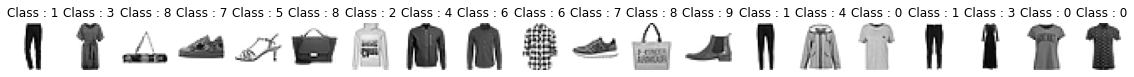

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.values

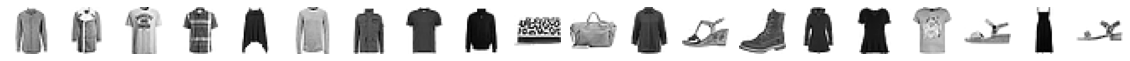

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [13]:
BATCH_SIZE = 128
EPOCHS = 100

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [15]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [17]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [18]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

### Mish

In [19]:
# Mish activation function 정의
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

### Weight Initialization + Batch Normalization + Optimization + Dropout

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.BatchNorm1d(256),
            Mish(),
            nn.Dropout(0.1)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            Mish(),
            nn.Dropout(0.1)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            Mish(),
            nn.Dropout(0.1)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(64, 10)
        )

        self._init_weight_()

    def _init_weight_(self):
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [21]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # weight_decay : 모델의 weight의 제곱합에 제약을 걸어 loss를 최소화
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.1, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.1, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.1, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [22]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5859, 	Train Accuracy: 81.43 %, 	Val Loss: 0.3979, 	Val Accuracy: 85.71 % 

[EPOCH: 2], 	Train Loss: 0.4047, 	Train Accuracy: 85.46 %, 	Val Loss: 0.3766, 	Val Accuracy: 86.38 % 

[EPOCH: 3], 	Train Loss: 0.3765, 	Train Accuracy: 86.30 %, 	Val Loss: 0.3441, 	Val Accuracy: 87.50 % 

[EPOCH: 4], 	Train Loss: 0.3639, 	Train Accuracy: 86.65 %, 	Val Loss: 0.3670, 	Val Accuracy: 86.58 % 

[EPOCH: 5], 	Train Loss: 0.3553, 	Train Accuracy: 87.01 %, 	Val Loss: 0.3639, 	Val Accuracy: 86.93 % 

[EPOCH: 6], 	Train Loss: 0.3496, 	Train Accuracy: 87.13 %, 	Val Loss: 0.3465, 	Val Accuracy: 87.56 % 

[EPOCH: 7], 	Train Loss: 0.3374, 	Train Accuracy: 87.67 %, 	Val Loss: 0.3889, 	Val Accuracy: 86.21 % 

[EPOCH: 8], 	Train Loss: 0.3356, 	Train Accuracy: 87.62 %, 	Val Loss: 0.3911, 	Val Accuracy: 85.75 % 

[EPOCH: 9], 	Train Loss: 0.3282, 	Train Accuracy: 87.96 %, 	Val Loss: 0.3449, 	Val Accuracy: 87.55 % 

[EPOCH: 10], 	Train Loss: 0.3257, 	Train Accuracy: 88.28 %, 	Val Loss: 0.

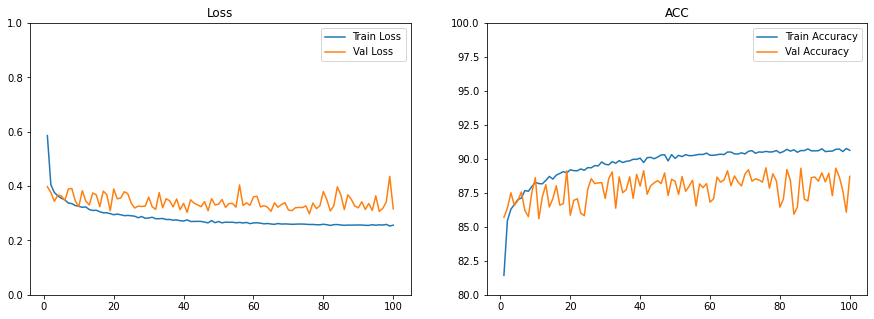

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()